# **1. Entendimiento del problema**

El gobierno australiano quiere concoer cuánto puede ser el costo del uso de corticoides y esteroides en el sistema de salud actual para preparar sus finanzas a futuro

# **2. Enfoque analítico**

Construir un modelo de regresión basado en series de tiempo que permiten estimar el costo de los corticoides y esteroides con el menor MAE posible

# **3. Requerimiento de datos**

Se requieren los datos pasados del costo de los medicamentos

# **4. Recolección de datos**

In [1]:
import matplotlib.pyplot as plt
from skforecast.datasets import fetch_dataset

In [2]:
data = fetch_dataset('h2o_exog')
data.index.name = 'datetime'

╭─────────────────────────────────── h2o_exog ────────────────────────────────────╮
│ Description:                                                                    │
│ Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health   │
│ system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are │
│ simulated.                                                                      │
│                                                                                 │
│ Source:                                                                         │
│ Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd      │
│ Edition). http://pkg.robjhyndman.com/fpp3package/,                              │
│ https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.             │
│                                                                                 │
│ URL:                                                                            │
│ https://raw.githubusercontent.com/skforecast/skforecast-                        │
│ datasets/main/data/h2o_exog.csv                                                 │
│                                                                                 │
│ Shape: 195 rows x 3 columns                                                     │
╰─────────────────────────────────────────────────────────────────────────────────╯

In [3]:
data

,y,exog_1,exog_2
datetime,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199
...,...,...,...
2008-02-01,0.761822,1.515840,1.786373
2008-03-01,0.649435,1.506258,1.694264
2008-04-01,0.827887,1.505253,1.627135


# **5. Exploración de Datos**

- Identificar los patrones estacionales de la serie
- Determinar la estacionariedad de la serie

In [4]:
from skforecast.plot import set_dark_theme
set_dark_theme()

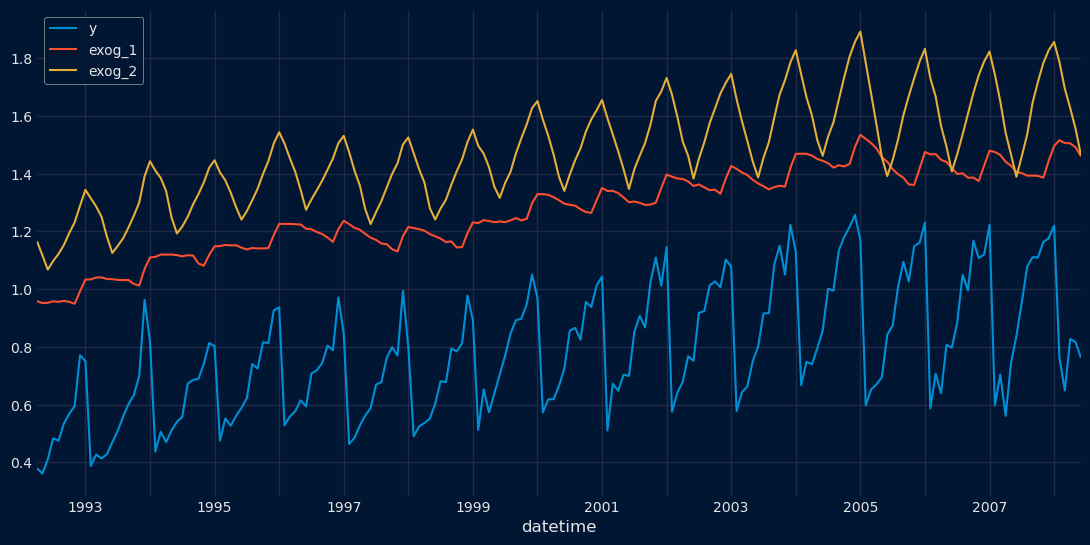

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
data.plot(ax=ax)
ax.legend()
plt.show()

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

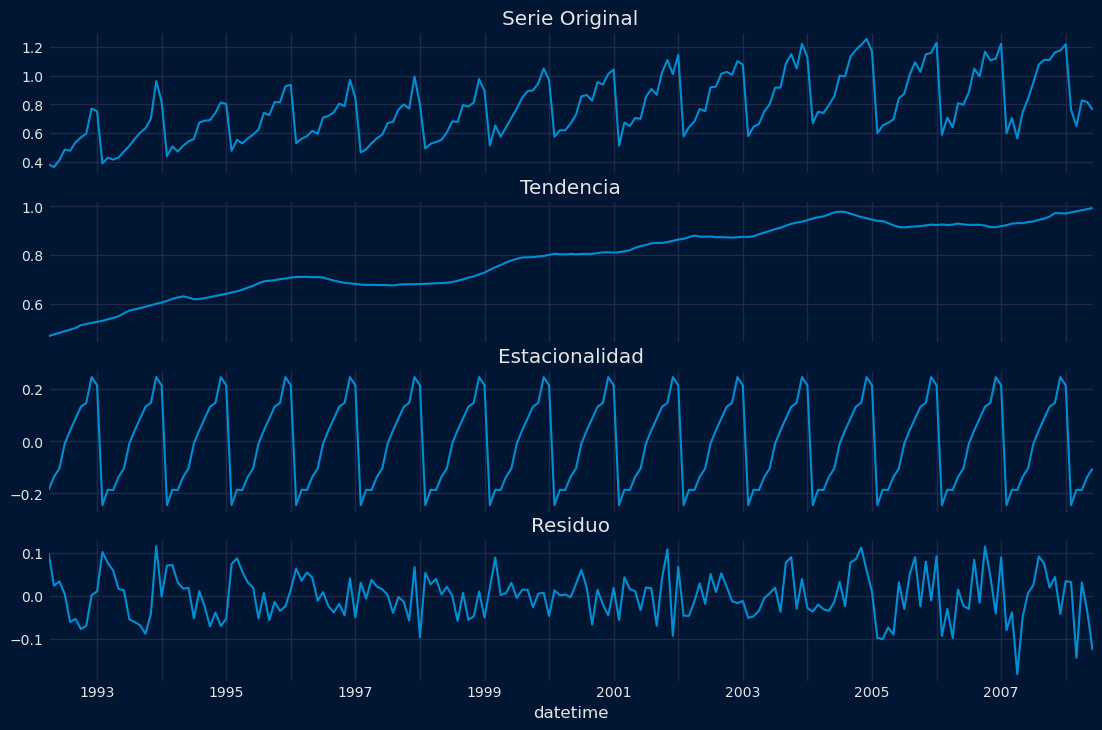

In [7]:
res_decompose = seasonal_decompose(data['y'], model='additive', extrapolate_trend='freq') # additive o multiplicative
fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
res_decompose.observed.plot(ax=ax[0])
ax[0].set_title('Serie Original')
res_decompose.trend.plot(ax=ax[1])
ax[1].set_title('Tendencia')
res_decompose.seasonal.plot(ax=ax[2])
ax[2].set_title('Estacionalidad')
res_decompose.resid.plot(ax=ax[3])
ax[3].set_title('Residuo')
plt.show()

**Análisis**

- M: 12 (Cada 12 periodos se repite el elemento de Componente Estacional)
- Residuo: ruido blanco

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
print('Test Estacionariedad de Dickey-Fuller Aumentado')
result = adfuller(data['y'])
print('ADF Estadístico:', result[0])
print('Valor p:', result[1])
print('Número de lags utilizados:', result[2])
print('Número de observaciones utilizadas para la regresión:', result[3])
print('Valores críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

Test Estacionariedad de Dickey-Fuller Aumentado
ADF Estadístico: -1.518045806093359
Valor p: 0.5245662008648596
Número de lags utilizados: 15
Número de observaciones utilizadas para la regresión: 179
Valores críticos:
   1%: -3.4674201432469816
   5%: -2.877826051844538
   10%: -2.575452082332012


**SE RECHAZA**

# **6. Preparación de los Datos**

- Diferenciar la serie (d = 1)
- Identificar su comportamiento estacional

Test Estacionariedad de Dickey-Fuller Aumentado
ADF Estadístico: -3.2725011930230257
Valor p: 0.016153320135670685


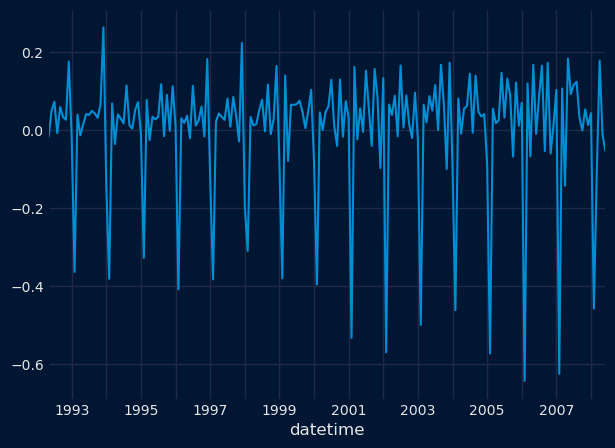

In [10]:
data_diff = data['y'].diff().dropna()
print('Test Estacionariedad de Dickey-Fuller Aumentado')
result = adfuller(data_diff)
print('ADF Estadístico:', result[0])
print('Valor p:', result[1])
data_diff.plot()
plt.show()

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### SARIMAX q

**q = 0**

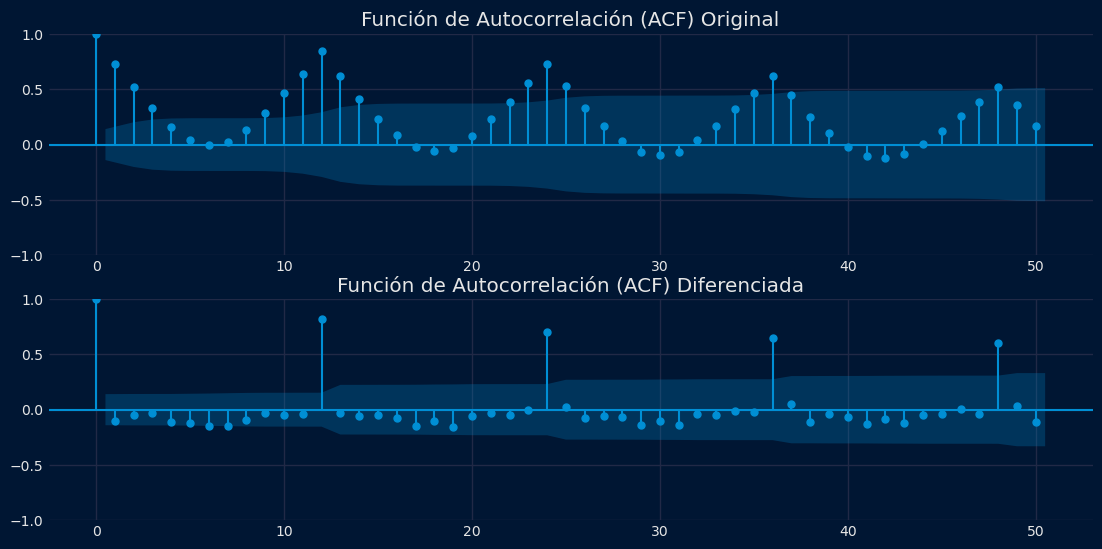

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(data['y'], lags=50, ax=ax[0], alpha=0.05)
ax[0].set_title('Función de Autocorrelación (ACF) Original')
plot_acf(data_diff, lags=50, ax=ax[1], alpha=0.05)
ax[1].set_title('Función de Autocorrelación (ACF) Diferenciada')
plt.show()

### SARIMAX p

**p = 0**

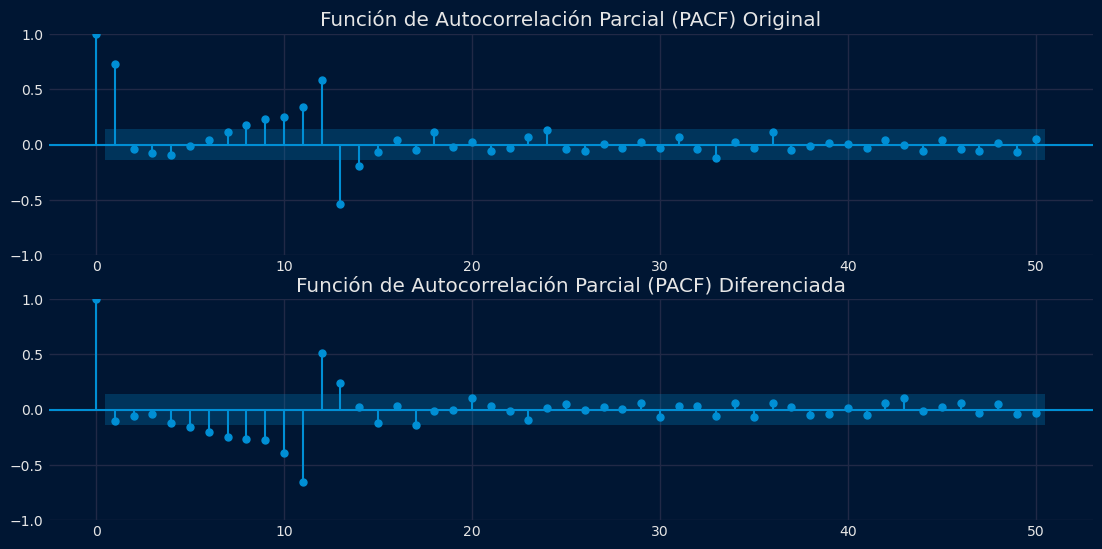

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_pacf(data['y'], lags=50, ax=ax[0], alpha=0.05)
ax[0].set_title('Función de Autocorrelación Parcial (PACF) Original')
plot_pacf(data_diff, lags=50, ax=ax[1], alpha=0.05)
ax[1].set_title('Función de Autocorrelación Parcial (PACF) Diferenciada')
plt.show()

### Diferenciación de la Serie Estacional

**D = 1**

In [14]:
data_diff_12 = data['y'].diff().diff(12).dropna()
adfuller_result = adfuller(data_diff_12)
print('Test Estacionariedad de Dickey-Fuller Aumentado')
print('ADF Estadístico:', adfuller_result[0])
print('Valor p:', adfuller_result[1])

Test Estacionariedad de Dickey-Fuller Aumentado
ADF Estadístico: -5.177607779375999
Valor p: 9.766313840442745e-06


**Q = 1**

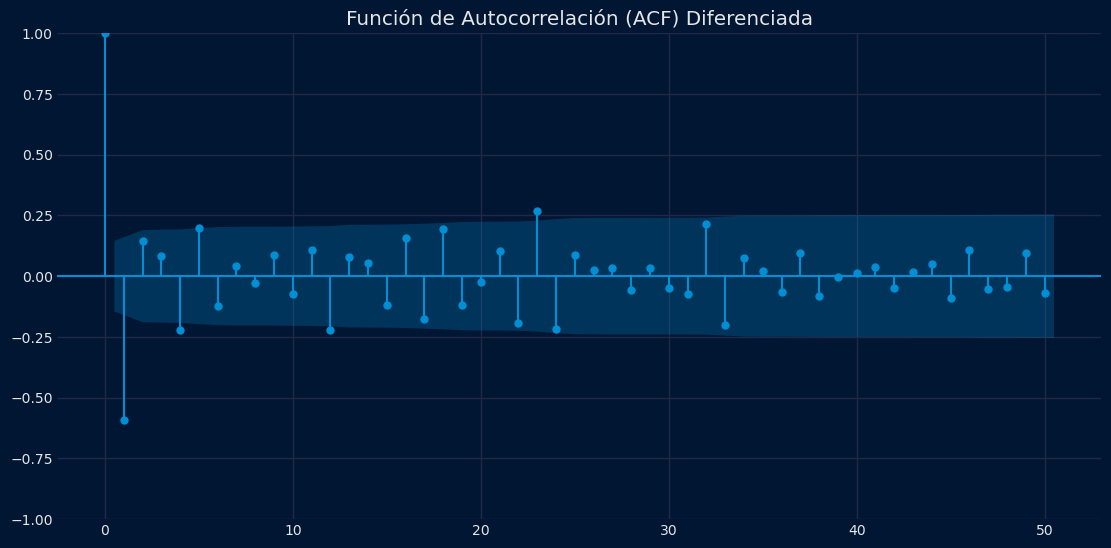

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(data_diff_12, lags=50, ax=ax, alpha=0.05)
ax.set_title('Función de Autocorrelación (ACF) Diferenciada')
plt.show()

**P = 2**

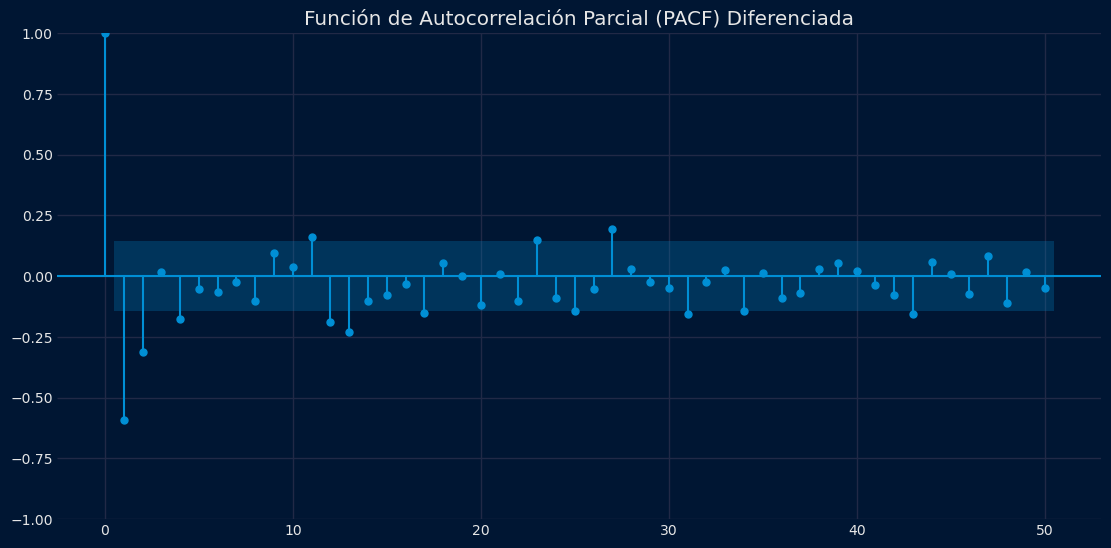

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(data_diff_12, lags=50, ax=ax, alpha=0.05)
ax.set_title('Función de Autocorrelación Parcial (PACF) Diferenciada')
plt.show()

### Conjunto de entrenamiento

In [17]:
end_train = '2003-12-01'
data_train = data['y'].loc[:end_train]
data_test = data['y'].loc[end_train:]

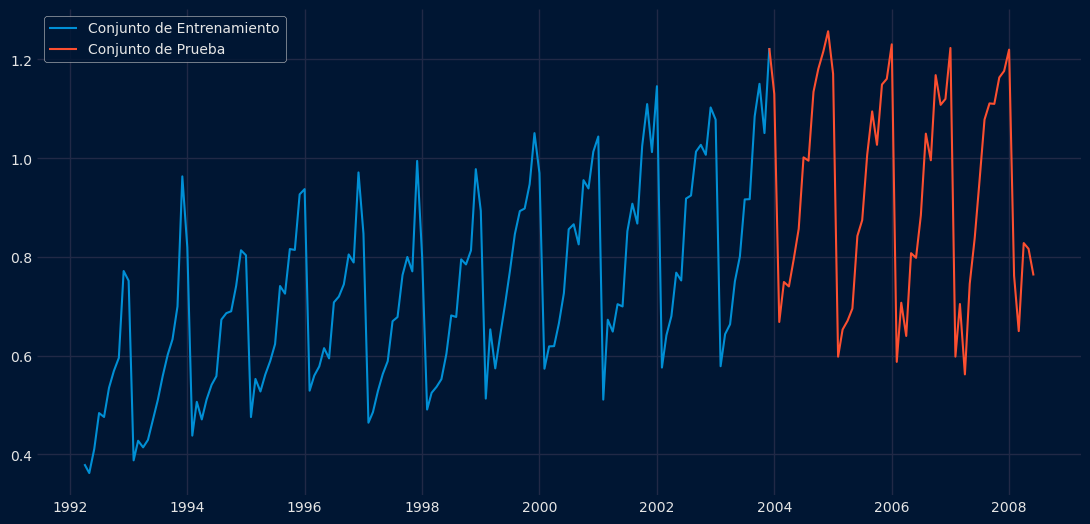

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(data_train, label='Conjunto de Entrenamiento')
plt.plot(data_test, label='Conjunto de Prueba')
plt.legend()
plt.show()

# **7. Modelos**

- SARIMAX
- Forecaster
- RNA Secuencial

### SARIMAX

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [20]:
modelo_sarimax = SARIMAX(data_train, order=(0, 1, 0), seasonal_order=(2, 1, 1, 12))
modelo_sarimax = modelo_sarimax.fit(disp=0)
modelo_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  141
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 178.682
Date:                              Wed, 22 Oct 2025   AIC                           -349.365
Time:                                      09:12:05   BIC                           -337.957
Sample:                                  04-01-1992   HQIC                          -344.729
                                       - 12-01-2003                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3998      0.203      1.971      0.049       0.002       0.798
ar.S.L24      -0.2299      0.132     -1.741      0.082      -0.489       0.029
ma.S.L12      -0.8179      0.260     -3.150      0.002      -1.327      -0.309
sigma2         0.0033      0.000      7.714      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                  35.77   Jarque-Bera (JB):                13.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.59   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
pred_sarimax = modelo_sarimax.get_forecast(steps=len(data_test)).predicted_mean
pred_sarimax.name = 'predicciones_sarimax'
pred_sarimax

2004-01-01    1.153829
2004-02-01    0.719769
2004-03-01    0.792593
2004-04-01    0.791209
2004-05-01    0.850653
2004-06-01    0.900779
2004-07-01    0.995946
2004-08-01    1.018139
2004-09-01    1.114323
2004-10-01    1.189412
2004-11-01    1.149221
2004-12-01    1.289539
2005-01-01    1.238601
2005-02-01    0.814651
2005-03-01    0.890714
2005-04-01    0.885057
2005-05-01    0.933636
2005-06-01    0.968530
2005-07-01    1.067097
2005-08-01    1.099283
2005-09-01    1.148693
2005-10-01    1.215416
2005-11-01    1.217371
2005-12-01    1.327294
2006-01-01    1.294034
2006-02-01    0.859001
2006-03-01    0.934568
2006-04-01    0.932127
2006-05-01    0.982732
2006-06-01    1.011559
2006-07-01    1.116188
2006-08-01    1.147387
2006-09-01    1.194554
2006-10-01    1.255840
2006-11-01    1.260939
2006-12-01    1.366084
2007-01-01    1.335647
2007-02-01    0.893858
2007-03-01    0.968482
2007-04-01    0.968309
2007-05-01    1.022223
2007-06-01    1.052126
2007-07-01    1.158396
2007-08-01 

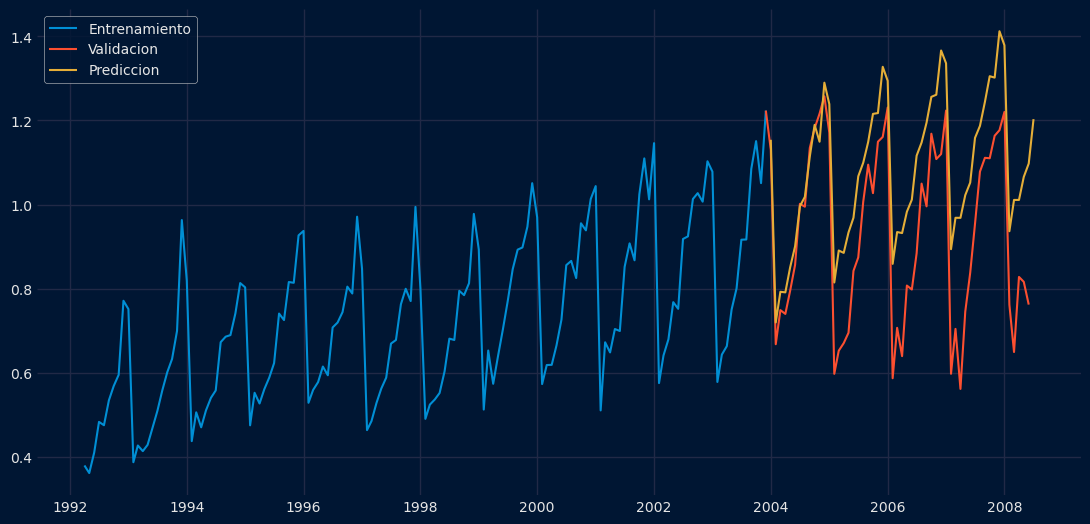

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(data_train, label="Entrenamiento")
plt.plot(data_test, label="Validacion")
plt.plot(pred_sarimax, label="Prediccion")
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_percentage_error
mape_sarimax = mean_absolute_percentage_error(data_test, pred_sarimax)
mape_sarimax

0.26359006215754843

### ML

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.plot import plot_prediction_intervals

#### Regresion Lineal

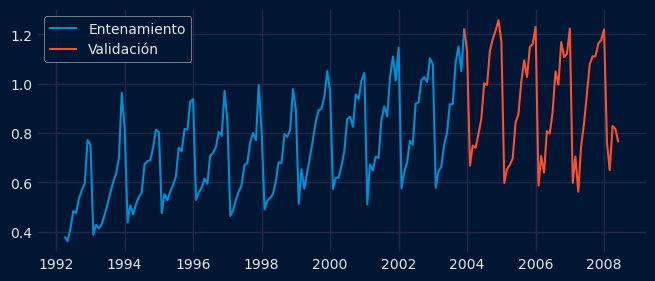

In [25]:
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.legend()
plt.show()

In [26]:
forecaster1 = ForecasterRecursive(regressor= LinearRegression(),
                                   lags = 15, window_features= RollingFeatures(stats=['mean'], window_sizes = 10))
forecaster1.fit(y = data_train, store_in_sample_residuals=True)
forecaster1

=================== 
ForecasterRecursive 
=================== 
Regressor: LinearRegression 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window features: ['roll_mean_10'] 
Window size: 15 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2003-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2025-10-22 09:12:09 
Last fit date: 2025-10-22 09:12:09 
Skforecast version: 0.18.0 
Python version: 3.13.5 
Forecaster id: None

In [27]:
predictions1 = forecaster1.predict(steps = len(data_test))
predictions1

2004-01-01    1.111554
2004-02-01    0.639690
2004-03-01    0.689112
2004-04-01    0.698062
2004-05-01    0.786592
2004-06-01    0.852667
2004-07-01    0.944152
2004-08-01    0.962054
2004-09-01    1.135455
2004-10-01    1.180984
2004-11-01    1.093922
2004-12-01    1.240321
2005-01-01    1.106812
2005-02-01    0.665317
2005-03-01    0.690337
2005-04-01    0.705423
2005-05-01    0.798573
2005-06-01    0.878663
2005-07-01    0.956437
2005-08-01    0.991798
2005-09-01    1.170185
2005-10-01    1.201430
2005-11-01    1.124880
2005-12-01    1.246809
2006-01-01    1.095354
2006-02-01    0.681203
2006-03-01    0.686018
2006-04-01    0.706667
2006-05-01    0.806932
2006-06-01    0.898985
2006-07-01    0.967262
2006-08-01    1.019203
2006-09-01    1.200567
2006-10-01    1.220776
2006-11-01    1.151890
2006-12-01    1.249643
2007-01-01    1.082657
2007-02-01    0.692560
2007-03-01    0.680140
2007-04-01    0.705687
2007-05-01    0.814464
2007-06-01    0.916657
2007-07-01    0.978775
2007-08-01 

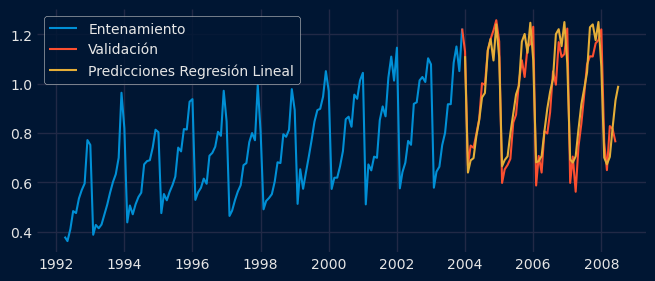

In [28]:
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.plot(predictions1, label = 'Predicciones Regresión Lineal')
plt.legend()
plt.show()

In [29]:
mean_absolute_percentage_error(data_test, predictions1)

0.14838096190284825

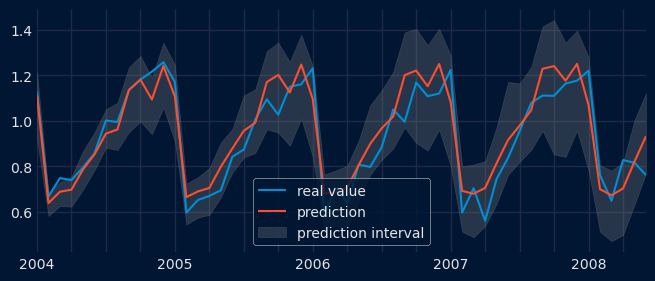

In [30]:
predictions1_interval = forecaster1.predict_interval(steps= len(data_test) - 1, interval = [5,95], 
                                                     method = 'bootstrapping', n_boot = 100)
plot_prediction_intervals(predictions=predictions1_interval, y_true=data_test, target_variable= 'y',
                           kwargs_fill_between={'color': 'gray', 'alpha':0.3})

#### Árboles de Decisión

In [31]:
forecaster2 = ForecasterRecursive(regressor= DecisionTreeRegressor(random_state=42),
                                   lags = 15, window_features= RollingFeatures(stats=['mean'], window_sizes = 10))
forecaster2.fit(y = data_train, store_in_sample_residuals=True)
forecaster2

=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window features: ['roll_mean_10'] 
Window size: 15 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2003-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-10-22 09:12:12 
Last fit date: 2025-10-22 09:12:12 
Skforecast version: 0.18.0 
Python version: 3.13.5 
Forecaster id: None

In [32]:
predictions2 = forecaster2.predict(steps = len(data_test))
predictions2

2004-01-01    1.078145
2004-02-01    0.618996
2004-03-01    0.726520
2004-04-01    0.719502
2004-05-01    0.800746
2004-06-01    0.855865
2004-07-01    0.916361
2004-08-01    0.897900
2004-09-01    1.084659
2004-10-01    1.150648
2004-11-01    1.078145
2004-12-01    1.145868
2005-01-01    1.078145
2005-02-01    0.846186
2005-03-01    0.744324
2005-04-01    0.744324
2005-05-01    0.994389
2005-06-01    0.924368
2005-07-01    1.084659
2005-08-01    1.013198
2005-09-01    1.078145
2005-10-01    1.078145
2005-11-01    1.078145
2005-12-01    1.078145
2006-01-01    1.078145
2006-02-01    1.013198
2006-03-01    1.013198
2006-04-01    1.013198
2006-05-01    1.078145
2006-06-01    1.078145
2006-07-01    1.078145
2006-08-01    1.078145
2006-09-01    1.078145
2006-10-01    1.078145
2006-11-01    1.078145
2006-12-01    1.078145
2007-01-01    1.078145
2007-02-01    1.078145
2007-03-01    1.078145
2007-04-01    1.078145
2007-05-01    1.078145
2007-06-01    1.078145
2007-07-01    1.078145
2007-08-01 

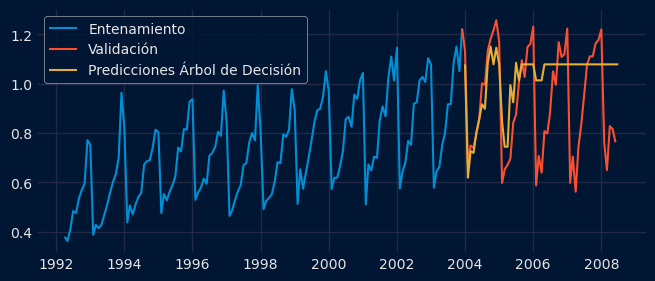

In [33]:
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.plot(predictions2, label = 'Predicciones Árbol de Decisión')
plt.legend()
plt.show()

In [34]:
mean_absolute_percentage_error(data_test, predictions2)

0.22674741840245308

In [35]:
data.loc

In [36]:
from skforecast.model_selection import grid_search_forecaster, random_search_forecaster, TimeSeriesFold #busqueda exhaustiva y aleatorizada de hiperparámetros
forecaster2 = ForecasterRecursive(regressor= DecisionTreeRegressor(random_state=42),
                                  lags = 10)
#Búsqueda de la ventana
lags_grid = {'lags_1':3, 'lags_2':10, 'lags_3':[1,2,3,12] }#el comportamiento se repite cada 12 periodos
#Búsqueda de hiperparámetros del regresor
param_grid = {'max_depth':[5,10,20], 'criterion':['squared_error', 'poisson', 'absolute_error', 'friedman_mse']}#4*3*3 = 36 búsquedas 
                                        #exhaustivas pq es la cantidad total de hiperparámetros, por eso no es tan grande esta búsqueda. 
#Folds
cv = TimeSeriesFold(steps = 12, initial_train_size = len(data_test), refit = False)#El refit false lo que hace es no meter 
                    #las predicciones a la búsqueda, es por decirlo así otro hiperparámetro que no las mete para evitar el sobreajuste
#Implementación de la búsqueda
results = grid_search_forecaster(forecaster=forecaster2, 
                                 y=data_train, param_grid=param_grid, lags_grid=lags_grid, cv=cv, metric= 'mean_squared_error',
                                 return_best=True, n_jobs=-1, verbose=False, show_progress=True)
#el njobs -1 lo que hace es utilizar todos los núcleos disponibles de la máquina para la búsqueda, 
# poniendo todo lo demás que este corriendo en segundo plano con la minima (-1)
results

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/12 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 12] 
  Parameters: {'criterion': 'absolute_error', 'max_depth': 5}
  Backtesting metric: 0.008137813902720652


,lags,lags_label,params,mean_squared_error,criterion,max_depth
0,"[1, 2, 3, 12]",lags_3,"{'criterion': 'absolute_error', 'max_depth': 5}",0.008138,absolute_error,5
1,"[1, 2, 3, 12]",lags_3,"{'criterion': 'absolute_error', 'max_depth': 20}",0.008439,absolute_error,20
2,"[1, 2, 3, 12]",lags_3,"{'criterion': 'absolute_error', 'max_depth': 10}",0.008439,absolute_error,10
3,"[1, 2, 3, 12]",lags_3,"{'criterion': 'friedman_mse', 'max_depth': 20}",0.009701,friedman_mse,20
4,"[1, 2, 3, 12]",lags_3,"{'criterion': 'friedman_mse', 'max_depth': 10}",0.009701,friedman_mse,10
5,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 10}",0.009774,squared_error,10
6,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 20}",0.009774,squared_error,20
7,"[1, 2, 3, 12]",lags_3,"{'criterion': 'friedman_mse', 'max_depth': 5}",0.009899,friedman_mse,5
8,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 5}",0.009899,squared_error,5
9,"[1, 2, 3, 12]",lags_3,"{'criterion': 'poisson', 'max_depth': 5}",0.021059,poisson,5


In [37]:
forecaster2

=================== 
ForecasterRecursive 
=================== 
Regressor: DecisionTreeRegressor 
Lags: [ 1  2  3 12] 
Window features: None 
Window size: 12 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2003-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 5,
    'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf':
    0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'} 
fit_kwargs: {} 
Creation date: 2025-10-22 09:12:13 
Last fit date: 2025-10-22 09:12:24 
Skforecast version: 0.18.0 
Python version: 3.13.5 
Forecaster id: None

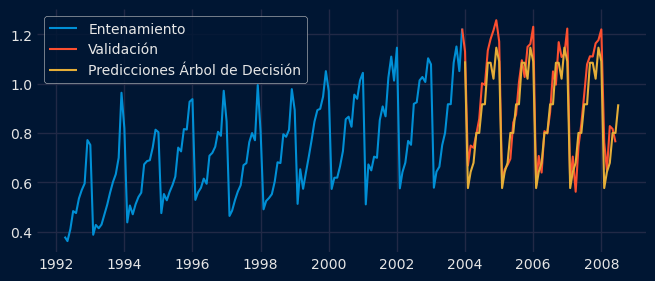

In [38]:
predictions2 = forecaster2.predict(len(data_test))
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.plot(predictions2, label = 'Predicciones Árbol de Decisión')
plt.legend()
plt.show()

In [39]:
mean_absolute_percentage_error(data_test, predictions2)

0.11941843098736717

#### Bosques Aleatorios

In [40]:
from skforecast.model_selection import grid_search_forecaster, random_search_forecaster, TimeSeriesFold #busqueda exhaustiva y aleatorizada de hiperparámetros
forecaster3 = ForecasterRecursive(regressor= RandomForestRegressor(random_state=42),
                                  lags = 10)
#Búsqueda de la ventana
lags_grid = {'lags_1':3, 'lags_2':10, 'lags_3':[1,2,3,12] }#el comportamiento se repite cada 12 periodos
#Búsqueda de hiperparámetros del regresor
param_grid = {'max_depth':[5,10,20], 'criterion':['squared_error', 'poisson', 'absolute_error', 'friedman_mse'],
               'n_estimators':[100,200,300]}#4*3*3*3 = 108 búsquedas 
                                        #exhaustivas pq es la cantidad total de hiperparámetros, por eso no es tan grande esta búsqueda. 
#Folds
cv = TimeSeriesFold(steps = 12, initial_train_size = len(data_test), refit = False)#El refit false lo que hace es no meter 
                    #las predicciones a la búsqueda, es por decirlo así otro hiperparámetro que no las mete para evitar el sobreajuste
#Implementación de la búsqueda
results = grid_search_forecaster(forecaster=forecaster3, 
                                 y=data_train, param_grid=param_grid, lags_grid=lags_grid, cv=cv, metric= 'mean_squared_error',
                                 return_best=True, n_jobs=-1, verbose=False, show_progress=True)
#el njobs -1 lo que hace es utilizar todos los núcleos disponibles de la máquina para la búsqueda, 
# poniendo todo lo demás que este corriendo en segundo plano con la minima (-1)
results

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 12] 
  Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.01196170358969139


,lags,lags_label,params,mean_squared_error,criterion,max_depth,n_estimators
0,"[1, 2, 3, 12]",lags_3,"{'criterion': 'squared_error', 'max_depth': 5,...",0.011962,squared_error,5,100
1,"[1, 2, 3, 12]",lags_3,"{'criterion': 'friedman_mse', 'max_depth': 5, ...",0.012240,friedman_mse,5,100
2,"[1, 2, 3, 12]",lags_3,"{'criterion': 'poisson', 'max_depth': 5, 'n_es...",0.012249,poisson,5,100
3,"[1, 2, 3, 12]",lags_3,"{'criterion': 'friedman_mse', 'max_depth': 20,...",0.012252,friedman_mse,20,300
4,"[1, 2, 3, 12]",lags_3,"{'criterion': 'friedman_mse', 'max_depth': 10,...",0.012252,friedman_mse,10,300
...,...,...,...,...,...,...,...
103,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",lags_2,"{'criterion': 'squared_error', 'max_depth': 5,...",0.058237,squared_error,5,100
104,"[1, 2, 3]",lags_1,"{'criterion': 'squared_error', 'max_depth': 5,...",0.058407,squared_error,5,300
105,"[1, 2, 3]",lags_1,"{'criterion': 'squared_error', 'max_depth': 10...",0.058685,squared_error,10,300
106,"[1, 2, 3]",lags_1,"{'criterion': 'poisson', 'max_depth': 5, 'n_es...",0.058949,poisson,5,300


In [41]:
forecaster3

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [ 1  2  3 12] 
Window features: None 
Window size: 12 
Series name: y 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2003-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    5, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-10-22 09:12:25 
Last fit date: 2025-10-22 09:13:21 
Skforecast version: 0.18.0 
Python version: 3.13.5 
Forecaster id: None

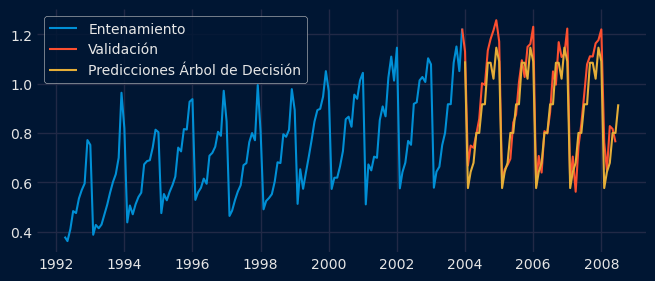

In [ ]:
predictions3 = forecaster3.predict(len(data_test))
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.plot(predictions3, label = 'Predicciones Árbol de Decisión')
plt.legend()
plt.show()

In [43]:
mean_absolute_percentage_error(data_test, predictions3)

0.11941843098736717

### Redes Neuronales Recurrentes

**LSTM:** Long Shot Term Memory
- Estado de la neurona 
- Entrada
- Estado de la memoria

In [ ]:
import pandas as pd

In [ ]:
from skforecast.deep_learning import ForecasterRnn, create_and_compile_model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
model_rna = create_and_compile_model(series= pd.DataFrame(data_train),
                                     levels= ['y'], lags=24, steps=1,
                                     recurrent_layer='RNN',
                                     recurrent_units=100,
                                     dense_units=64)
model_rna.summary()

In [ ]:
forecaster4 = ForecasterRnn(regressor= model_rna,
                            levels= ['y'], lags=24,
                            transformer_series=MinMaxScaler(),
                            fit_kwargs={'epochs': 25,
                                        'batch_size': 512,
                                        'callbacks': [EarlyStopping(monitor='val_loss', restore_best_weights=True)],
                                        'series_val': pd.DataFrame(data_test)
                                        })
forecaster4.fit(y= pd.DataFrame(data_train))

In [ ]:
forecaster4

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))
plot = forecaster4.plot_history(ax=ax)

In [ ]:
from skforecast.model_selection import backtesting_forecaster_multiseries
cv = TimeSeriesFold(steps = forecaster4.max_step,
                    initial_train_size = len(data_train),
                    refit = False)
metrics, predictions4 = backtesting_forecaster_multiseries(forecaster = forecaster4,
                                                            series = pd.DataFrame(data['Gasoleos']),
                                                            cv = cv, levels = forecaster4.levels,
                                                            metric = 'mean_absolute_percentage_error', verbose = False)

In [ ]:
metrics

In [ ]:
predictions4

In [ ]:
plt.figure(figsize=(7,3))
plt.plot(data_train, label = 'Entenamiento')
plt.plot(data_test, label = 'Validación')
plt.plot(predictions4['pred'], label = 'Predicciones RNN')
plt.legend()
plt.show()